### Mode Convertion of a Taper Waveguide

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import meep as mp

mp.verbosity(0)
plt.style.use("/home/hungling/meep/presentation.mplstyle")

In [2]:
wavelength = 1.31  # Wavelength in µm
n_Si = 2.99463     # TE-like effective index 2.99463 (1.31 µm) | 2.84813 (1.55 µm)
# n_Si = 2.40246     # TM-like effective index 2.40246  (1.31 µm) | 2.05368 (1.55 µm) 
n_SiO2 = 1.44672   # 1.44672 (1.31 µm) | 1.44400 (1.55 µm)
w1 = 0.41  # Width of waveguide 1
w2 = 2.0   # width of waveguide 2
w_oxide = 2.0  # Width of oxide cladding
L1 = 2.0  # Length of waveguides 1 (at least 2 µm)
L2 = 2.0  # Length of waveguides 2 (at least 2 µm)
Lt = 2.0  # Length of taper waveguide
d_pml_x = 1.0   # Size of PML in x direction
d_pml_y = 1.0   # Size of PML in y direction
resolution = 25  # pixels/μm
fcen = 1/wavelength

In [15]:
## Geometry (input/output waveguides connected by a linear taper)
lx = L1 + Lt + L2
ly = w_oxide + max(w1,w2) + w_oxide
sx = d_pml_x + lx + d_pml_x
sy = d_pml_y + ly + d_pml_y
# symmetries = [mp.Mirror(mp.Y)]

vertices = [mp.Vector3(-sx/2, w1/2),
            mp.Vector3(-lx/2+L1, w1/2),
            mp.Vector3(lx/2-L2, w2/2),
            mp.Vector3(sx/2, w2/2),
            mp.Vector3(sx/2, -w2/2),
            mp.Vector3(lx/2-L2, -w2/2),
            mp.Vector3(-lx/2+L1, -w1/2),
            mp.Vector3(-sx/2, -w1/2)]

geometry = [mp.Prism(vertices, height=mp.inf, material=mp.Medium(index=n_Si))]

## Light Source
sources = [mp.EigenModeSource(src = mp.GaussianSource(fcen, fwidth=0.1*fcen),  # Gaussian-pulse source
                              center = mp.Vector3(-lx/2, 0),
                              size = mp.Vector3(0, ly),
                              eig_parity = mp.ODD_Y + mp.EVEN_Z,  # Ey polarization (TE-like mode)
                              # eig_parity = mp.ODD_Z + mp.EVEN_Y,  # Ez polarization (TM-like mode)
                              eig_band = 1)] 
## Simulation object
sim = mp.Simulation(resolution = resolution,
                    cell_size = mp.Vector3(sx, sy, 0),
                    boundary_layers = [mp.PML(d_pml_x, direction=mp.X), mp.PML(d_pml_y, direction=mp.Y)],
                    geometry = geometry,
                    sources = sources,
                    # symmetries = symmetries,  # Results in discontinuous field across y=0 ?
                    default_material = mp.Medium(index=n_SiO2))
## Monitor
## add_flux(fcen, df, nfreq, freq, FluxRegions)
## nfreq of equally space frequencies covering the range fcen-df/2 to fcen+df/2
## or freq array/list of arbitrary frequencies
pt1 = mp.Vector3(-lx/2 + int(L1/2*10)/10, 0)
pt2 = mp.Vector3(lx/2 - int(L2/2*10)/10, 0)
flux_in = sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=pt1, size=mp.Vector3(0, ly)))
flux_out = sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=pt2, size=mp.Vector3(0, ly)))

monitor = sim.add_dft_fields([mp.Ey, mp.Hz], fcen, 0, 1, center=mp.Vector3(), size=mp.Vector3(lx, ly))

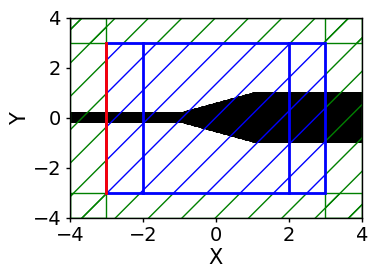

In [16]:
fig, ax = plt.subplots(figsize=(4,3))
sim.plot2D(ax=ax)
ax.axis('auto')
fig.tight_layout()

In [17]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(100, mp.Ey, pt2, 1e-9))  # TE-like mode
# sim.run(until_after_sources=mp.stop_when_fields_decayed(100, mp.Ez, pt2, 1e-9))  # TM-like mode

In [30]:
incident_flux = mp.get_fluxes(flux_in)
ref = sim.get_eigenmode_coefficients(flux_in, [1], eig_parity=mp.ODD_Y+mp.EVEN_Z)  # Ey polarization (TE-like mode)
print("Incident flux:", incident_flux)
print("Incident coefficients:", ref.alpha[0,0,:])
print("Forward: %.6g" % abs(ref.alpha[0,0,0])**2)  # Forward
print("Backward: %.6g" % abs(ref.alpha[0,0,1])**2)  # Backward, should be nearly zero
print('-'*20)

tran_flux = mp.get_fluxes(flux_out)
res = sim.get_eigenmode_coefficients(flux_out, [1], eig_parity=mp.ODD_Y+mp.EVEN_Z)  # Ey polarization (TE-like mode)
print("Transmitted flux", tran_flux)
print("Outcome coefficients", res.alpha[0,0,:])
print("Forward: %.6g" % abs(res.alpha[0,0,0])**2)
print("Backward: %.6g" % abs(res.alpha[0,0,1])**2)

Incident flux: [176.54397499411505]
Incident coefficients: [13.19437421+1.58056882j -0.22823227+0.03150853j]
Forward: 176.59
Backward: 0.0530828
--------------------
Transmitted flux [176.50476644156606]
Outcome coefficients [ 9.60830346-7.66456061j -0.20340399+0.16326317j]
Forward: 151.065
Backward: 0.068028


In [31]:
transmission = abs(res.alpha[0,0,0])**2 / incident_flux[0]
transmission_total = tran_flux[0] / incident_flux[0]
print(f"Transmission to fundamental mode: {transmission*100:.2f} %")
print(f"Insertion loss: {10*np.log10(transmission):.4g} dB")
print(f"Total power transmission: {transmission_total*100:.2f} %")

Transmission to fundamental mode: 85.57 %
Insertion loss: -0.6769 dB
Total power transmission: 99.98 %


In [20]:
field = sim.get_dft_array(monitor, mp.Ey, 0)
[x, y, z, w] = sim.get_array_metadata(dft_cell=monitor)

print(field.shape)
print(x.shape)
print(y.shape)

(152, 152)
(152,)
(152,)


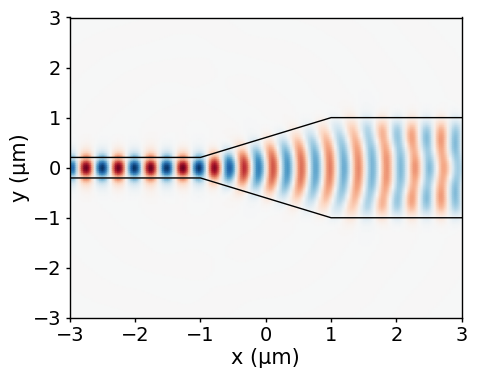

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
# ax.pcolormesh(x, y, np.rot90(np.abs(field)), cmap="inferno", shading="gouraud")
ax.pcolormesh(x, y, np.rot90(np.real(field)), cmap="RdBu", shading="gouraud")
ax.add_patch(Polygon([(p.x, p.y) for p in vertices], fill=False, lw=1, ec='k'))
ax.axis("auto")
ax.set_xlim([-lx/2, lx/2])
ax.set_ylim([-ly/2, ly/2])
ax.set(xlabel="x (µm)", ylabel="y (µm)")
fig.tight_layout()

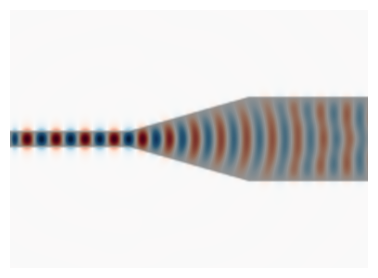

In [28]:
eps_data = sim.get_array(center = mp.Vector3(),
                         size = mp.Vector3(lx, ly),
                         component = mp.Dielectric)

fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(eps_data.T, cmap="gray_r", interpolation="spline36")
ax.imshow(np.real(field).T, interpolation="spline36", cmap="RdBu", alpha=0.6)
ax.axis("auto")
ax.axis("off")
fig.tight_layout()

#### For multiple wavelengths

In [33]:
wavelengths = np.linspace(1.26, 1.36, 21)
freqs = 1/wavelengths

sim = mp.Simulation(resolution = resolution,
                    cell_size = mp.Vector3(sx, sy, 0),
                    boundary_layers = [mp.PML(d_pml_x, direction=mp.X), mp.PML(d_pml_y, direction=mp.Y)],
                    geometry = geometry,
                    sources = sources,
                    default_material = mp.Medium(index=n_SiO2))

pt1 = mp.Vector3(-lx/2 + int(L1/2*10)/10, 0)
pt2 = mp.Vector3(lx/2 - int(L2/2*10)/10, 0)
flux_in = sim.add_flux(freqs, mp.FluxRegion(center=pt1, size=mp.Vector3(0, ly)))
flux_out = sim.add_flux(freqs, mp.FluxRegion(center=pt2, size=mp.Vector3(0, ly)))

In [34]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(100, mp.Ey, pt2, 1e-9))  # TE-like mode
# sim.run(until_after_sources=mp.stop_when_fields_decayed(100, mp.Ez, pt2, 1e-9))  # TM-like mode

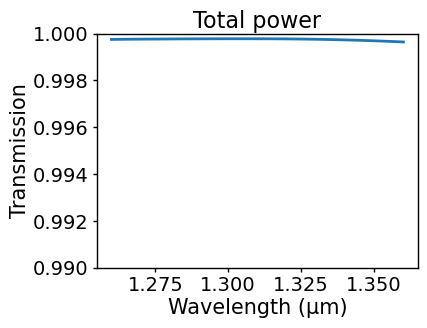

In [55]:
incident_flux = mp.get_fluxes(flux_in)  # list
tran_flux = mp.get_fluxes(flux_out)  # list
transmission_total = np.array(tran_flux) / np.array(incident_flux)

fig, ax = plt.subplots(figsize=(4.5,3.5))
ax.plot(wavelengths, transmission_total)
ax.set(ylim=[0.99, 1.0])
ax.set(xlabel="Wavelength (µm)", ylabel="Transmission")
ax.set_title("Total power")
fig.tight_layout()

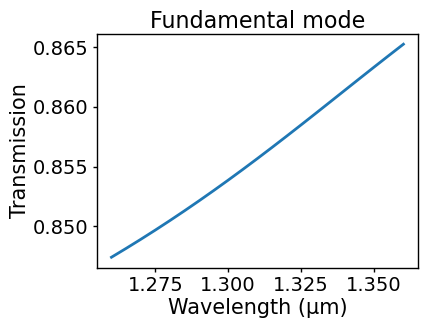

In [56]:
ref = sim.get_eigenmode_coefficients(flux_in, [1], eig_parity=mp.ODD_Y+mp.EVEN_Z)  
res = sim.get_eigenmode_coefficients(flux_out, [1], eig_parity=mp.ODD_Y+mp.EVEN_Z)
# alpha returns array (bands, frequencies, 2) for forward and backward eigenmode coefficients
transmission = np.abs(res.alpha[0,:,0])**2 / np.array(incident_flux)

fig, ax = plt.subplots(figsize=(4.5,3.5))
ax.plot(wavelengths, transmission)
ax.set(xlabel="Wavelength (µm)", ylabel="Transmission")
ax.set_title("Fundamental mode")
fig.tight_layout()